# Week 8

**`Market-Simulation::evaluation-metrics::moments`**
* up to forth order
* visualization

**`Market-Simulation::evaluation-metrics::arbitrage`**
* quadratic programming
* random agent
* reinforcement agent

In [1]:
# change current working directory
%cd ..

/Users/omega/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# data provider
from qtrader.envs.data_loader import Finance
# pandas.DataFrame cleaner
from qtrader.utils.pandas import clean
# machine floating-point relative accuracy
from qtrader.utils.numpy import eps
# unique id generator
from qtrader.utils import uuid

# YAML parser
import yaml

# scientific programming
import numpy as np
import pandas as pd
import scipy.stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_8.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")
print(f"rolling window size: {config['window']}")

start date: 2010-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'VOD', 'GS', 'TSLA', 'MMM']
rolling window size: 20


### Data Source

Fetch prices, simple-relative returns and log-returns.

In [4]:
# prices
prices = clean(Finance.Prices(config['tickers'],
                              config['start_date'],
                              freq=config['freq'],
                              csv=config['csv_file_prices']))


# returns
returns = clean(Finance.Returns(config['tickers'],
                                config['start_date'],
                                freq=config['freq'],
                                csv=config['csv_file_returns']))

# log-returns
rhos = np.log(1 + returns)

### `Moments`

Test statistical moments consistency and deviation between original and generated series.

### First Order

Test percentage deviations of first order moments of two distributions.

In [5]:
def first_order(df_1, df_2, log=False, render=False):
    """First order moments comparison test.
    
    Parameters
    ----------
    df_1: pandas.DataFrame
        Family 1 data.
    df_2: pandas.DataFrame
        Family 2 data.
    log: bool, optional
        Flag for printing summary.
    render: bool, optional
        Flag for printing distributions.
    
    Returns
    -------
    summary: dict
        First order test summary.
    """
    # type check
    assert isinstance(df_1, pd.DataFrame)
    assert isinstance(df_2, pd.DataFrame)
    # interface check
    assert (df_1.columns == df_2.columns).all()
    # column-wise mean values
    mu_1 = df_1.mean(axis=0)
    mu_2 = df_2.mean(axis=0)
    # relative deviation of mean values
    dmu = np.abs((mu_1+eps) / (mu_2+eps) - 1)
    # column-wise median values
    median_1 = df_1.median(axis=0)
    median_2 = df_2.median(axis=0)
    dmedian = np.abs((median_1+eps) / (median_2+eps) - 1)
    # column-size mode values
    mode_1 = df_1.mode(axis=0).iloc[0]
    mode_2 = df_2.mode(axis=0).iloc[0]
    dmode = np.abs((mode_1+eps) / (mode_2+eps) - 1)
    # summary table for each ticker
    summary = {}
    # iterate over tickers
    for ticker in df_1:
        # summary table columns
        _name1 = 'series 1'
        _name2 = 'series 2'
        _name3 = 'deviations'
        summary[ticker] = pd.DataFrame({_name1: [mu_1[ticker], median_1[ticker], mode_1[ticker]],
                                        _name2: [mu_2[ticker], median_2[ticker], mode_1[ticker]],
                                        _name3: [dmu[ticker], dmedian[ticker], dmode[ticker]]},
                                       columns=[_name1, _name2, _name3],
                                       index=['mean', 'median', 'mode'])
    # print summary
    if log:
        for ticker, summ in summary.items():
            print(ticker)
            print(summ)
            print('\n')
    # plot distributions
    if render:
        # random selection of assets to render
        I = np.sort(np.random.choice(df_1.shape[1], min(3, df_1.shape[1]), replace=False))
        # initialize figure & axes
        fig, axes = plt.subplots(ncols=len(I), nrows=2, sharex=True, figsize=(6.4 * len(I), 4.8))
        for i, m in enumerate(I):
            # distribution plot of family 1
            sns.distplot(df_1.iloc[:, m], label='%s' %
                         df_1.columns[m], color='g', norm_hist=True, ax=axes[0, i])
            # distribution plot of family 2
            sns.distplot(df_2.iloc[:, m], label='%s' %
                         df_1.columns[m], color='r', norm_hist=True, ax=axes[1, i])
            # y-axis limits
            ymin_1, ymax_1 = axes[0, i].get_ylim()
            ymin_2, ymax_2 = axes[1, i].get_ylim()
            ymin = min(ymin_1, ymin_2)
            ymax = max(ymax_1, ymax_2)
            # vertical line for mean of family 1
            axes[0, i].vlines(mu_1.iloc[m], ymin, ymax, label='%s::mean' %
                              df_1.columns[m], color='g', linestyles='-')
            # vertical line for median of family 1
            axes[0, i].vlines(median_1.iloc[m], ymin, ymax, label='%s::median' %
                              df_1.columns[m], color='g', linestyles='-.')
            # vertical line for mode of family 1
            axes[0, i].vlines(mode_1.iloc[m], ymin, ymax, label='%s::mode' %
                              df_1.columns[m], color='g', linestyles='--')
            # vertical line for mean of family 2
            axes[1, i].vlines(mu_2.iloc[m], ymin, ymax, label='%s::mean' %
                              df_2.columns[m], color='r', linestyles='-')
            # vertical line for median of family 2
            axes[1, i].vlines(median_2.iloc[m], ymin, ymax, label='%s::median' %
                              df_2.columns[m], color='r', linestyles='-.')
            # vertical line for mode of family 2
            axes[1, i].vlines(mode_2.iloc[m], ymin, ymax, label='%s::mode' %
                              df_2.columns[m], color='r', linestyles='--')
            # setting for family 1
            axes[0, i].set(ylabel='Frequency', xlabel='', ylim=[ymin, ymax])
            axes[0, i].legend()
            # settings for family 2
            axes[1, i].set(ylabel='Frequency', xlabel='', ylim=[ymin, ymax])
            axes[1, i].legend()
        # present figure
        fig.show()
    return summary

AAPL
        series 1  series 2  deviations
mean    0.001054  0.000925    0.138724
median  0.000897  0.000897    0.000448
mode    0.000000  0.000000    0.000000


GE
        series 1  series 2  deviations
mean    0.000374  0.000283    0.321124
median  0.000322  0.000322    0.000161
mode    0.000000  0.000000    0.000000


JPM
        series 1  series 2  deviations
mean    0.000670  0.000534    0.254623
median  0.000521  0.000521    0.000260
mode    0.000000  0.000000    0.000000


MSFT
        series 1  series 2  deviations
mean    0.000725  0.000626    0.157918
median  0.000323  0.000323    0.000162
mode    0.000000  0.000000    0.000000


GS
        series 1  series 2  deviations
mean    0.000367  0.000228    0.613106
median  0.000776  0.000776    0.000388
mode    0.000000  0.000000    0.000000


MMM
        series 1  series 2  deviations
mean    0.000689  0.000625    0.102478
median  0.000737  0.000736    0.000368
mode    0.000000  0.000000    0.000000




/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated,

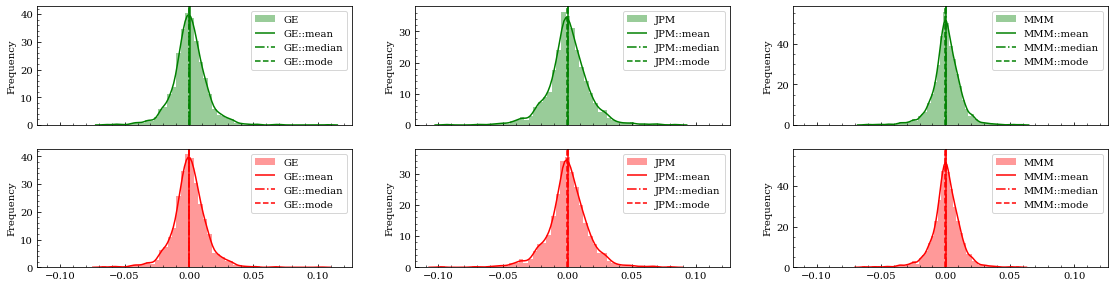

In [6]:
# first order statistics overview
summary_first_order = first_order(returns, rhos, log=True, render=True)

### Second Order

Test percentage deviations of second order moments. Perform Bartlett, Levene and Fligner-Killeen tests
to test variance similarity.

In [7]:
def second_order(df_1, df_2, log=False, render=False):
    """Second order moments comparison test.
    
    Parameters
    ----------
    df_1: pandas.DataFrame
        Family 1 data.
    df_2: pandas.DataFrame
        Family 2 data.
    log: bool, optional
        Flag for printing summary.
    render: bool, optional
        Flag for printing distributions.
    
    Returns
    -------
    summary: dict
        Second order test summary.
    """
    # type check
    assert isinstance(df_1, pd.DataFrame)
    assert isinstance(df_2, pd.DataFrame)
    # interface check
    assert (df_1.columns == df_2.columns).all()
    # covariance matrix of family 1
    cov_1 = df_1.cov()
    # frobenius norm of family 1
    fro_1 = np.linalg.norm(cov_1, ord='fro')
    # covariance matrix of family 2
    cov_2 = df_2.cov()
    # frobenius norm of family 2
    fro_2 = np.linalg.norm(cov_2, ord='fro')
    # relative deviation of covariances
    # normalized by frobenius norms
    dcov = np.linalg.norm(cov_1 - cov_2, ord='fro') / \
        (np.sqrt(fro_1) * np.sqrt(fro_2) + eps)
    # column-wise std values
    std_1 = df_1.std(axis=0)
    std_2 = df_2.std(axis=0)
    # relative deviation of std values
    dstd = np.abs((std_1+eps) / (std_2+eps) - 1)
    # summary table for each ticker
    summary = {}
    # iterate over tickers
    for ticker in df_1:
        # Bartlett test
        bartlett_s, bartlett_p = scipy.stats.bartlett(df_1[ticker], df_2[ticker])
        # Levene test
        levene_s, levene_p = scipy.stats.levene(df_1[ticker], df_2[ticker])
        # Fligner-Killeen test
        fligner_s, fligner_p = scipy.stats.fligner(df_1[ticker], df_2[ticker])
        # summary table columns
        _name1 = 'series 1'
        _name2 = 'series 2'
        _name3 = 'deviations'
        _name4 = 'statistic'
        _name5 = 'p-value (>0.05)'
        summary[ticker] = pd.DataFrame({_name1: [std_1[ticker], None, None, None],
                                        _name2: [std_2[ticker], None, None, None],
                                        _name3: [dstd[ticker], None, None, None],
                                        _name4: [None, bartlett_s, levene_s, fligner_s],
                                        _name5: [None, bartlett_p, levene_p, fligner_p]},
                                       columns=[_name1, _name2, _name3, _name4, _name5],
                                       index=['std', 'Bartlett', 'Levene', 'Fligner-Killeen'])
    # print summary
    if log:
        for ticker, summ in summary.items():
            print(ticker)
            print(summ)
            print('\n')
    # plot covariance matrices
    if render:
        # random selection of assets to render
        I = np.sort(np.random.choice(
            df_1.shape[1], min(3, df_1.shape[1]), replace=False))
        # fetch sub-matrices
        sub_cov_1 = cov_1.values[np.ix_(I, I)]
        sub_cov_2 = cov_2.values[np.ix_(I, I)]
        # half-cov mask
        mask = np.ones_like(sub_cov_1)
        mask[np.triu_indices_from(mask)] = False
        # initialize figure & axes
        fig, axes = plt.subplots(ncols=3, figsize=(19.2, 4.8))
        # family 1
        sns.heatmap(sub_cov_1, xticklabels=df_1.columns[I], yticklabels=df_1.columns[I],
                    ax=axes[0], mask=mask, cmap=plt.cm.Greys)
        axes[0].set(title='Covariance Matrix: Series 1')
        # family 2
        sns.heatmap(sub_cov_2, xticklabels=df_2.columns[I], yticklabels=df_2.columns[I],
                    ax=axes[1], mask=mask, cmap=plt.cm.Greys)
        axes[1].set(title='Covariance Matrix: Series 2')
        # absolute difference
        sns.heatmap(np.abs(sub_cov_1 - sub_cov_2),
                    xticklabels=df_1.columns[I], yticklabels=df_1.columns[I],
                    ax=axes[2], mask=mask, cmap=plt.cm.Greys)
        axes[2].set(title='Covariance Matrix: Absolute Difference')
        # present figure
        fig.show()
    return summary

AAPL
                 series 1  series 2  deviations  statistic  p-value (>0.05)
std              0.015991  0.016001    0.000625        NaN              NaN
Bartlett              NaN       NaN         NaN   0.000777         0.977769
Levene                NaN       NaN         NaN   0.000517         0.981869
Fligner-Killeen       NaN       NaN         NaN   0.000662         0.979471


GE
                 series 1  series 2  deviations  statistic  p-value (>0.05)
std              0.013491  0.013473    0.001277        NaN              NaN
Bartlett              NaN       NaN         NaN   0.003237         0.954626
Levene                NaN       NaN         NaN   0.000157         0.990013
Fligner-Killeen       NaN       NaN         NaN   0.000735         0.978372


JPM
                 series 1  series 2  deviations  statistic  p-value (>0.05)
std              0.016484   0.01649    0.000319        NaN              NaN
Bartlett              NaN       NaN         NaN   0.000203         0.988

/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


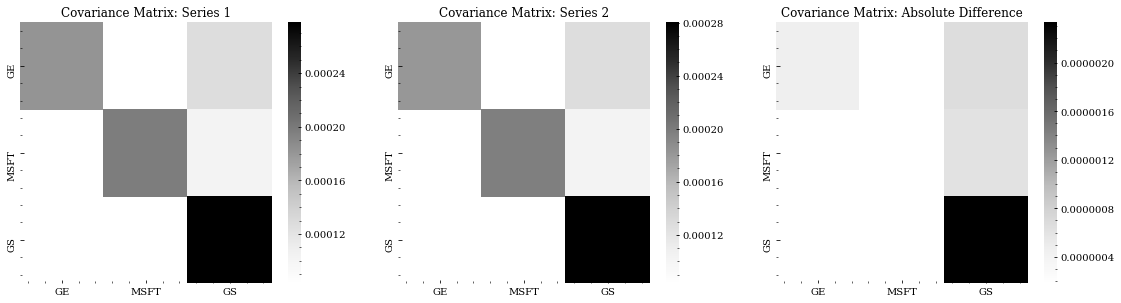

In [8]:
# second order statistics overview
summary_second_order = second_order(returns, rhos, log=True, render=True)

### Third Order

Test percentage deviations of third order moments. Perform Skewness test to check deviations from normal distribution.

In [9]:
def third_order(df_1, df_2, log=False, render=False):
    """Third order moments comparison test.
    
    Parameters
    ----------
    df_1: pandas.DataFrame
        Family 1 data.
    df_2: pandas.DataFrame
        Family 2 data.
    log: bool, optional
        Flag for printing summary.
    render: bool, optional
        Flag for printing distributions.
    
    Returns
    -------
    summary: dict
        Third order test summary.
    """
    # type check
    assert isinstance(df_1, pd.DataFrame)
    assert isinstance(df_2, pd.DataFrame)
    # interface check
    assert (df_1.columns == df_2.columns).all()
    # column-wise skewness values
    skew_1 = df_1.skew(axis=0)
    skew_2 = df_2.skew(axis=0)
    # relative deviation of skewness values
    dskew = np.abs((skew_1+eps) / (skew_2+eps) - 1)
    # summary table for each ticker
    summary = {}
    # iterate over tickers
    for ticker in df_1:
        # Skewness test for family 1
        skewtest_s_1, skewtest_p_1 = scipy.stats.skewtest(df_1[ticker])
        # Skewness test for family 2
        skewtest_s_2, skewtest_p_2 = scipy.stats.skewtest(df_2[ticker])
        # summary table columns
        _name1 = 'series 1'
        _name2 = 'series 2'
        _name3 = 'deviations'
        summary[ticker] = pd.DataFrame({_name1: [skew_1[ticker], skewtest_s_1, skewtest_p_1],
                                        _name2: [skew_2[ticker], skewtest_s_2, skewtest_p_2],
                                        _name3: [dskew[ticker], None, None]},
                                       columns=[_name1, _name2, _name3],
                                       index=['skewness', 'skewtest statistic', 'skewtest p-value (>0.05)'])
    # print summary
    if log:
        for ticker, summ in summary.items():
            print(ticker)
            print(summ)
            print('\n')
    # plot distributions
    if render:
        # random selection of assets to render
        I = np.sort(np.random.choice(df_1.shape[1], min(3, df_1.shape[1]), replace=False))
        # initialize figure & axes
        fig, axes = plt.subplots(ncols=len(I), nrows=2, sharex=True, figsize=(6.4 * len(I), 4.8))
        for i, m in enumerate(I):
            # normal distribution with family 1's statistics
            mu_1 = df_1.iloc[:, m].mean()
            std_1 = df_1.iloc[:, m].std()
            norm_1 = np.random.normal(mu_1, std_1, 10*df_1.iloc[:, m].count())
            sns.distplot(norm_1, label='$\mathcal{N}(%.4f, %.4f)$' %
                         (mu_1, std_1), color='k', norm_hist=True, ax=axes[0, i])
            # distribution plot of family 1
            sns.distplot(df_1.iloc[:, m], label='%s' %
                         df_1.columns[m], color='g', norm_hist=True, ax=axes[0, i])
            # normal distribution with family 2's statistics
            mu_2 = df_2.iloc[:, m].mean()
            std_2 = df_2.iloc[:, m].std()
            norm_2 = np.random.normal(mu_2, std_2, 10*df_2.iloc[:, m].count())
            sns.distplot(norm_2, label='$\mathcal{N}(%.4f, %.4f)$' %
                         (mu_2, std_2), color='k', norm_hist=True, ax=axes[1, i])
            # distribution plot of family 2
            sns.distplot(df_2.iloc[:, m], label='%s' %
                         df_1.columns[m], color='r', norm_hist=True, ax=axes[1, i])
            # y-axis limits
            ymin_1, ymax_1 = axes[0, i].get_ylim()
            ymin_2, ymax_2 = axes[1, i].get_ylim()
            ymin = min(ymin_1, ymin_2)
            ymax = max(ymax_1, ymax_2)
            # setting for family 1
            axes[0, i].set(ylabel='Frequency', xlabel='', ylim=[ymin, ymax])
            axes[0, i].legend()
            # settings for family 2
            axes[1, i].set(ylabel='Frequency', xlabel='', ylim=[ymin, ymax])
            axes[1, i].legend()
        # present figure
        fig.show()
    return summary

AAPL
                          series 1  series 2  deviations
skewness                 -0.101652 -0.262711    0.613064
skewtest statistic       -1.851610 -4.719285         NaN
skewtest p-value (>0.05)  0.064082  0.000002         NaN


GE
                          series 1  series 2  deviations
skewness                  0.224004  0.092329    1.426143
skewtest statistic        4.041581  1.682532         NaN
skewtest p-value (>0.05)  0.000053  0.092466         NaN


JPM
                          series 1  series 2  deviations
skewness                 -0.024998 -0.162936    0.846578
skewtest statistic       -0.456425 -2.956270         NaN
skewtest p-value (>0.05)  0.648084  0.003114         NaN


MSFT
                          series 1  series 2  deviations
skewness                  0.095391 -0.107883    1.884208
skewtest statistic        1.738092 -1.964486         NaN
skewtest p-value (>0.05)  0.082195  0.049474         NaN


GS
                              series 1      series 2  deviat

/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated,

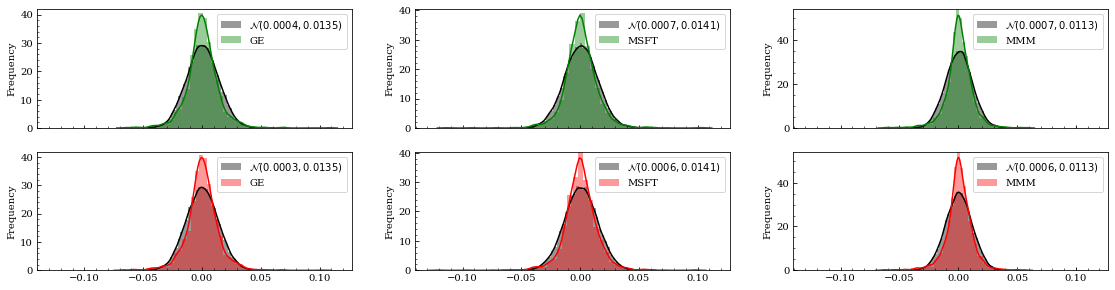

In [10]:
# third order statistics overview
summary_third_order = third_order(returns, rhos, log=True, render=True)

### Forth Order

Test percentage deviations of forth order moments. Perform Kurtosis test to check deviations from normal distribution.

In [11]:
def forth_order(df_1, df_2, log=False, render=False):
    """Forth order moments comparison test.
    
    Parameters
    ----------
    df_1: pandas.DataFrame
        Family 1 data.
    df_2: pandas.DataFrame
        Family 2 data.
    log: bool, optional
        Flag for printing summary.
    render: bool, optional
        Flag for printing distributions.
    
    Returns
    -------
    summary: dict
        Forth order test summary.
    """
    # type check
    assert isinstance(df_1, pd.DataFrame)
    assert isinstance(df_2, pd.DataFrame)
    # interface check
    assert (df_1.columns == df_2.columns).all()
    # column-wise kurtosis values
    kurt_1 = df_1.kurt(axis=0)
    kurt_2 = df_2.kurt(axis=0)
    # relative deviation of kurtosis values
    dkurt = np.abs((kurt_1+eps) / (kurt_2+eps) - 1)
    # summary table for each ticker
    summary = {}
    # iterate over tickers
    for ticker in df_1:
        # Kurtosis test for family 1
        kurtosistest_s_1, kurtosistest_p_1 = scipy.stats.kurtosistest(df_1[ticker])
        # Kurtosis test for family 2
        kurtosistest_s_2, kurtosistest_p_2 = scipy.stats.kurtosistest(df_2[ticker])
        # summary table columns
        _name1 = 'series 1'
        _name2 = 'series 2'
        _name3 = 'deviations'
        summary[ticker] = pd.DataFrame({_name1: [kurt_1[ticker], kurtosistest_s_1, kurtosistest_p_1],
                                        _name2: [kurt_2[ticker], kurtosistest_s_2, kurtosistest_p_2],
                                        _name3: [dkurt[ticker], None, None]},
                                       columns=[_name1, _name2, _name3],
                                       index=['skewness', 'kurtosistest statistic', 'kurtosistest p-value (>0.05)'])
    # print summary
    if log:
        for ticker, summ in summary.items():
            print(ticker)
            print(summ)
            print('\n')
    # plot distributions
    if render:
        # random selection of assets to render
        I = np.sort(np.random.choice(df_1.shape[1], min(3, df_1.shape[1]), replace=False))
        # initialize figure & axes
        fig, axes = plt.subplots(ncols=len(I), nrows=2, sharex=True, figsize=(6.4 * len(I), 4.8))
        for i, m in enumerate(I):
            # normal distribution with family 1's statistics
            mu_1 = df_1.iloc[:, m].mean()
            std_1 = df_1.iloc[:, m].std()
            norm_1 = np.random.normal(mu_1, std_1, 10*df_1.iloc[:, m].count())
            sns.distplot(norm_1, label='$\mathcal{N}(%.4f, %.4f)$' %
                         (mu_1, std_1), color='k', norm_hist=True, ax=axes[0, i])
            # distribution plot of family 1
            sns.distplot(df_1.iloc[:, m], label='%s' %
                         df_1.columns[m], color='g', norm_hist=True, ax=axes[0, i])
            # normal distribution with family 2's statistics
            mu_2 = df_2.iloc[:, m].mean()
            std_2 = df_2.iloc[:, m].std()
            norm_2 = np.random.normal(mu_2, std_2, 10*df_2.iloc[:, m].count())
            sns.distplot(norm_2, label='$\mathcal{N}(%.4f, %.4f)$' %
                         (mu_2, std_2), color='k', norm_hist=True, ax=axes[1, i])
            # distribution plot of family 2
            sns.distplot(df_2.iloc[:, m], label='%s' %
                         df_1.columns[m], color='r', norm_hist=True, ax=axes[1, i])
            # y-axis limits
            ymin_1, ymax_1 = axes[0, i].get_ylim()
            ymin_2, ymax_2 = axes[1, i].get_ylim()
            ymin = min(ymin_1, ymin_2)
            ymax = max(ymax_1, ymax_2)
            # setting for family 1
            axes[0, i].set(ylabel='Frequency', xlabel='', ylim=[ymin, ymax])
            axes[0, i].legend()
            # settings for family 2
            axes[1, i].set(ylabel='Frequency', xlabel='', ylim=[ymin, ymax])
            axes[1, i].legend()
        # present figure
        fig.show()
    return summary

AAPL
                                  series 1      series 2  deviations
skewness                      4.534668e+00  4.955355e+00    0.084895
kurtosistest statistic        1.443584e+01  1.495241e+01         NaN
kurtosistest p-value (>0.05)  3.078681e-47  1.502019e-50         NaN


GE
                                  series 1      series 2  deviations
skewness                      4.748366e+00  4.425491e+00    0.072958
kurtosistest statistic        1.470419e+01  1.429368e+01         NaN
kurtosistest p-value (>0.05)  6.059560e-49  2.396157e-46         NaN


JPM
                                  series 1      series 2  deviations
skewness                      3.549054e+00  3.648364e+00     0.02722
kurtosistest statistic        1.300538e+01  1.316627e+01         NaN
kurtosistest p-value (>0.05)  1.140379e-38  1.372020e-39         NaN


MSFT
                                  series 1      series 2  deviations
skewness                      7.531867e+00  7.806399e+00    0.035168
kurtosistes

/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated,

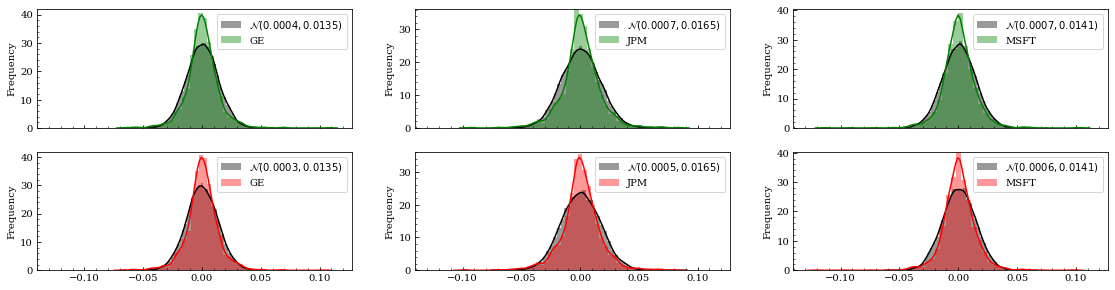

In [12]:
# forth order statistics overview
summary_forth_order = forth_order(returns, rhos, log=True, render=True)